<a href="https://colab.research.google.com/github/Pranchol/Smart-Traffic/blob/main/Smart_traffic_managment__system_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
pip install ultralytics

In [60]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import time

In [61]:
model = YOLO("yolov8s.pt")

In [62]:
# Vehicle class IDs from COCO dataset: Car, Motorcycle, Bus, Truck
vehicle_classes = [2, 3, 5, 7]

In [63]:
# Video paths for 4 directions of the intersection
video_paths = [
    "/content/path 1.mp4",
    "/content/path 2.mp4",
    "/content/path 3.mp4",
    "/content/path4.mp4"
]

In [64]:
 #Open all video captures
caps = [cv2.VideoCapture(path) for path in video_paths]
fps_list = [cap.get(cv2.CAP_PROP_FPS) for cap in caps]
total_frames_list = [int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) for cap in caps]
durations = [frames / fps if fps > 0 else 0 for frames, fps in zip(total_frames_list, fps_list)]


In [65]:
# Helper function to get vehicle count and draw bounding boxes
def process_frame(frame):
    results = model(frame, conf=0.1, verbose=False)[0]
    count = 0
    if results.boxes is not None:
        for box, cls in zip(results.boxes.xyxy, results.boxes.cls):
            if int(cls) in vehicle_classes:
                count += 1
                x1, y1, x2, y2 = map(int, box)
                label = model.names[int(cls)]
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return count, frame


In [66]:
# Per-video state tracking
video_times = [0, 0, 0, 0]  # Time in seconds for each video
total_vehicles = [0, 0, 0, 0]
total_green_times = [0, 0, 0, 0]


In [67]:
round_number = 1
simulation_running = True


In [68]:
!pip install deep_sort_realtime


In [69]:
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow

In [70]:
passed_vehicle_total = [0, 0, 0, 0]  # Track total vehicles that pass per path



 ROUND 1 START 
Path 1: 20 vehicles at 0.00s


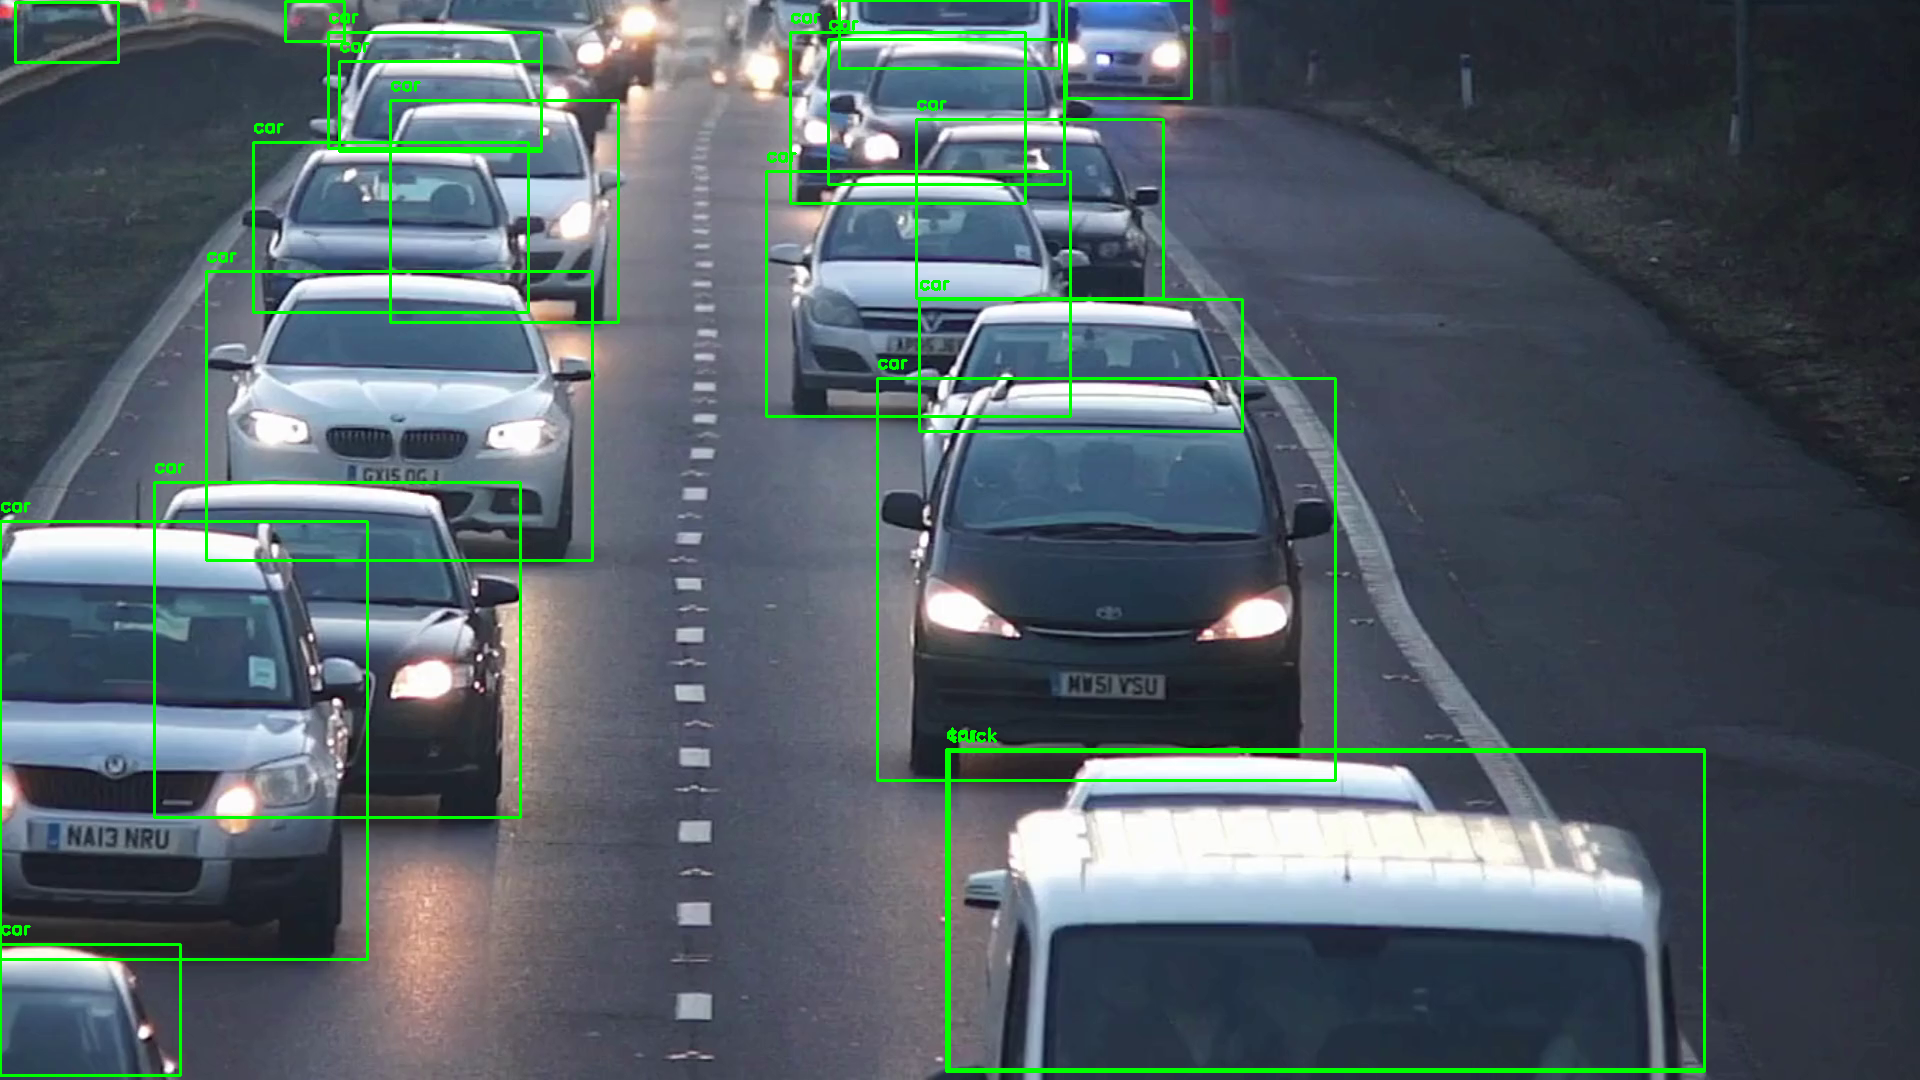

Path 2: 19 vehicles at 0.00s


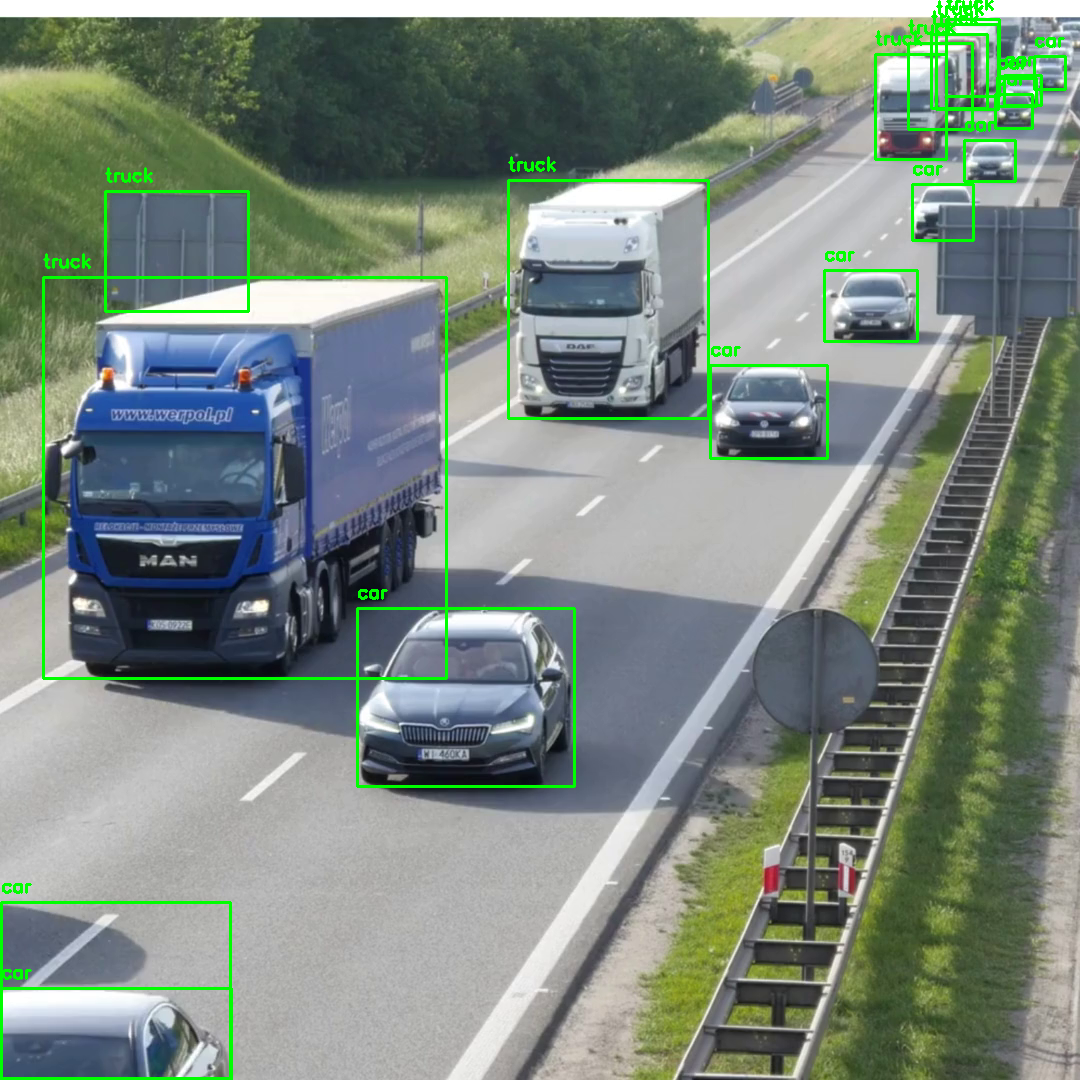

Path 3: 36 vehicles at 0.00s


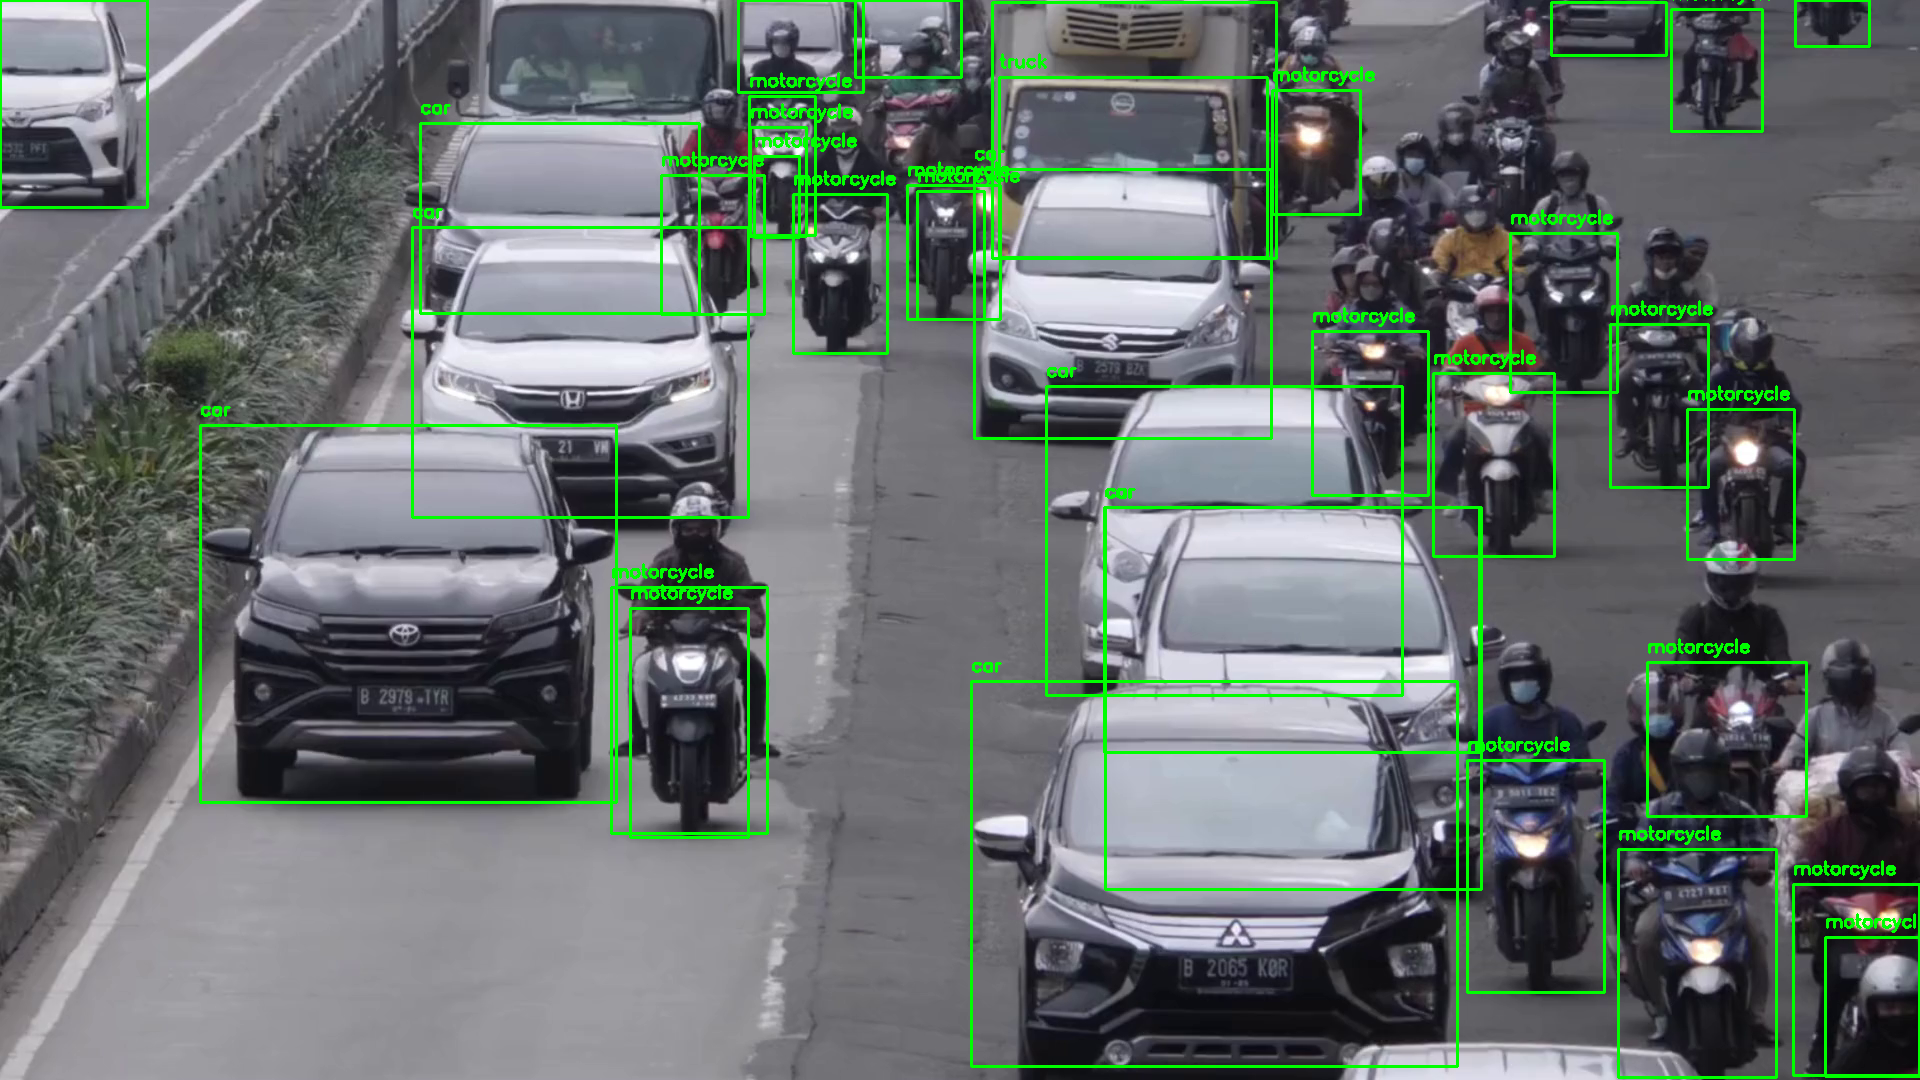

Path 4: 13 vehicles at 0.00s


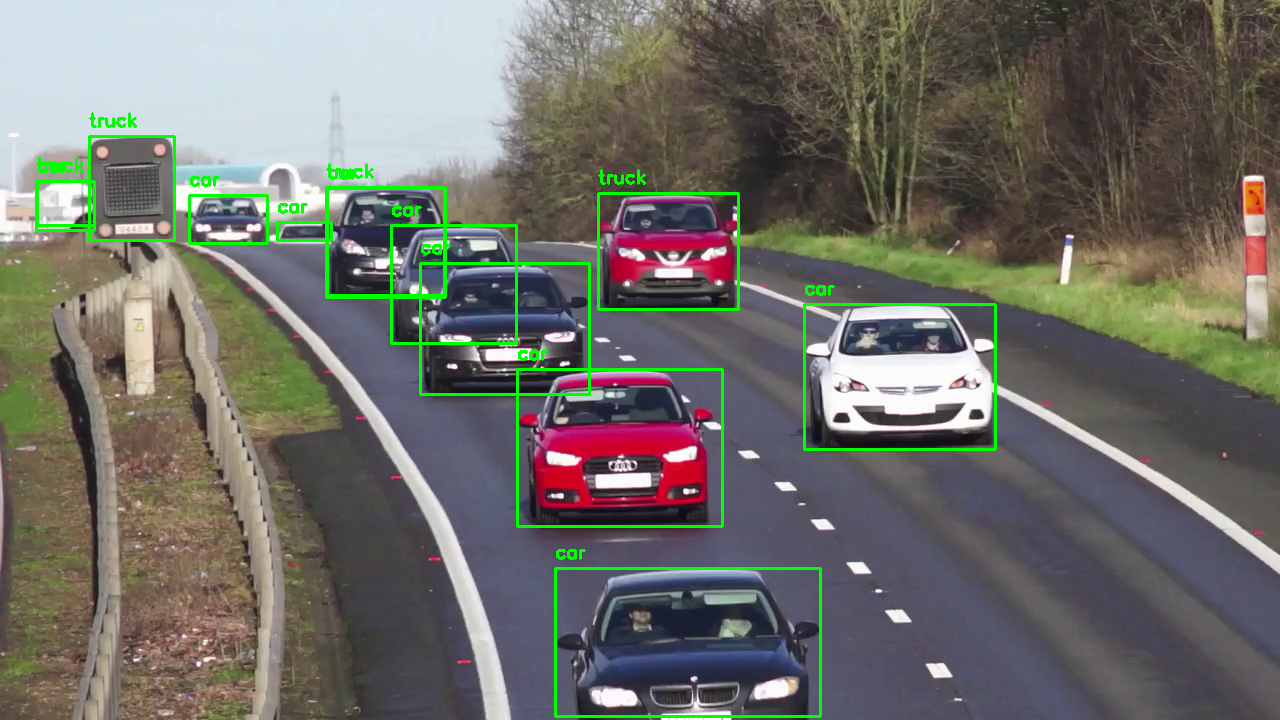


GREEN light for Path 3: 22 seconds
Path 3: Vehicles passed during green = 54

GREEN light for Path 1: 12 seconds
Path 1: Vehicles passed during green = 16

GREEN light for Path 2: 12 seconds
Path 2: Vehicles passed during green = 3

GREEN light for Path 4: 8 seconds
Path 4: Vehicles passed during green = 3

 Skipping 54 seconds in all video paths for next round frame capture.
Video for Path 1 ended after skipping. Terminating simulation.

=== FINAL TRAFFIC EFFICIENCY REPORT ===
Path 1: Vehicles Passed = 16, Green Time = 12s, Efficiency = 1.33 vehicles/second
Path 2: Vehicles Passed = 3, Green Time = 12s, Efficiency = 0.25 vehicles/second
Path 3: Vehicles Passed = 54, Green Time = 22s, Efficiency = 2.45 vehicles/second
Path 4: Vehicles Passed = 3, Green Time = 8s, Efficiency = 0.38 vehicles/second

Total Vehicles Passed: 76
Total Green Time Allocated: 54s

Overall Efficiency: 1.41 vehicles/second


In [71]:
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2

TOTAL_GREEN_TIME = 56  # total time per round
LINE_POSITION = 250    # line to detect vehicles crossing

# Initialize tracking variables
simulation_running = True
round_number = 1
passed_vehicle_total = [0, 0, 0, 0]   # vehicles passed during green light
total_green_times = [0, 0, 0, 0]      # green time given to each path
total_vehicles = [0, 0, 0, 0]         # vehicles detected at sampling frame

while simulation_running:
    print(f"\n ROUND {round_number} START ")

    # Step 1: Capture and process frames at current video_times
    vehicle_counts = []
    for i, cap in enumerate(caps):
        if video_times[i] >= durations[i]:
            print(f"Simulation ended: Path {i+1} video reached its end.")
            simulation_running = False
            break
        cap.set(cv2.CAP_PROP_POS_MSEC, video_times[i] * 1000)
        ret, frame = cap.read()
        if not ret:
            print(f"Path {i+1}: Could not read frame at {video_times[i]:.2f}s")
            vehicle_counts.append(0)
            continue
        count, annotated_frame = process_frame(frame)
        vehicle_counts.append(count)
        total_vehicles[i] += count
        print(f"Path {i+1}: {count} vehicles at {video_times[i]:.2f}s")
        cv2_imshow(annotated_frame)

    if not simulation_running:
        break

    # Step 2: Calculate efficiencies (avoid division by zero)
    efficiencies = []
    for i in range(4):
        if total_green_times[i] > 0:
            eff = passed_vehicle_total[i] / total_green_times[i]
        else:
            eff = 0
        efficiencies.append(eff)

    # Step 3: Normalize vehicle counts and efficiencies
    norm_counts = np.array(vehicle_counts) / (max(vehicle_counts) if max(vehicle_counts) > 0 else 1)
    norm_effs = np.array(efficiencies) / (max(efficiencies) if max(efficiencies) > 0 else 1)

    # Step 4: Compute scores
    weight_count = 0.6
    weight_eff = 0.4
    scores = weight_count * norm_counts + weight_eff * norm_effs

    # Step 5: Assign green times
    if scores.sum() > 0:
        green_times = (scores / scores.sum()) * TOTAL_GREEN_TIME
    else:
        green_times = np.array([TOTAL_GREEN_TIME / 4] * 4)

    green_times = green_times.astype(int)

    # Step 6: Sort paths in descending order of vehicle count
    path_order = sorted(range(4), key=lambda i: vehicle_counts[i], reverse=True)

    # Step 7: Show green lights and count passing vehicles
    for i in path_order:
        print(f"\nGREEN light for Path {i+1}: {green_times[i]} seconds")
        total_green_times[i] += green_times[i]

        tracker = DeepSort(max_age=30)
        counted_ids = set()

        for second in range(green_times[i], 0, -1):
            caps[i].set(cv2.CAP_PROP_POS_MSEC, video_times[i] * 1000)
            ret, frame = caps[i].read()
            if not ret:
                break

            results = model(frame, conf=0.1)[0]
            detections = []
            for box, cls, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
                class_id = int(cls)
                if class_id in vehicle_classes:
                    x1, y1, x2, y2 = map(int, box)
                    detections.append(([x1, y1, x2 - x1, y2 - y1], conf, class_id))

            tracks = tracker.update_tracks(detections, frame=frame)

            for track in tracks:
                if not track.is_confirmed():
                    continue
                track_id = track.track_id
                l, t, r, b = track.to_ltrb()
                cx, cy = int((l + r) / 2), int((t + b) / 2)

                if cy > LINE_POSITION and track_id not in counted_ids:
                    counted_ids.add(track_id)

                # Draw tracking info
                cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
                cv2.putText(frame, f'ID:{track_id}', (int(l), int(t) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Draw line and status
            cv2.line(frame, (0, LINE_POSITION), (frame.shape[1], LINE_POSITION), (0, 0, 255), 2)
            cv2.putText(frame, f"Green light time left: {second}s", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.putText(frame, f"Vehicles Passed: {len(counted_ids)}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            #cv2_imshow(frame)

            video_times[i] += 1

        # ✅ Store passed vehicle count for efficiency calculation
        vehicles_this_green = len(counted_ids)
        passed_vehicle_total[i] += vehicles_this_green
        print(f"Path {i+1}: Vehicles passed during green = {vehicles_this_green}")

    # Step 8: Advance video_times for next round
    time_to_skip = sum(green_times)
    print(f"\n Skipping {time_to_skip} seconds in all video paths for next round frame capture.")
    for i in range(4):
        video_times[i] += time_to_skip
        if video_times[i] >= durations[i]:
            print(f"Video for Path {i+1} ended after skipping. Terminating simulation.")
            simulation_running = False
            break

    round_number += 1

# === Final Efficiency  ===
total_passed = sum(passed_vehicle_total)
total_green_allocated = sum(total_green_times)

if total_green_allocated > 0:
    overall_efficiency_smart = total_passed / total_green_allocated
else:
    overall_efficiency_smart = 0

print("\n=== FINAL TRAFFIC EFFICIENCY REPORT ===")
for i in range(4):
    if total_green_times[i] > 0:
        path_efficiency = passed_vehicle_total[i] / total_green_times[i]
    else:
        path_efficiency = 0
    print(f"Path {i+1}: Vehicles Passed = {passed_vehicle_total[i]}, "
          f"Green Time = {total_green_times[i]}s, "
          f"Efficiency = {path_efficiency:.2f} vehicles/second")

print(f"\nTotal Vehicles Passed: {total_passed}")
print(f"Total Green Time Allocated: {total_green_allocated}s")
print(f"\nOverall Efficiency: {overall_efficiency_smart:.2f} vehicles/second")


In [72]:
from deep_sort_realtime.deepsort_tracker import DeepSort

# Constants
green_times = [12, 20, 6, 18]  # Green time in seconds per path
video_skip = 55                # Time to skip between rounds
LINE_POSITION = 650            # Line for vehicle count
simulation_running = True
round_number = 1

# Tracking variables
video_times = [0, 0, 0, 0]
passed_vehicle = [0, 0, 0, 0]
totalgreen_times = [0, 0, 0, 0]

while simulation_running:
    print(f"\n=== ROUND {round_number} START ===")

    for i in range(4):
        if video_times[i] >= durations[i]:
            print(f"Simulation ended: Path {i+1} video reached its end.")
            simulation_running = False
            break

        print(f"\nPath {i+1} GREEN for {green_times[i]} seconds")
        totalgreen_times[i] += green_times[i]

        # Reset tracker and counter
        tracker = DeepSort(max_age=30)
        counted_ids = set()

        for second in range(green_times[i]):
            caps[i].set(cv2.CAP_PROP_POS_MSEC, video_times[i] * 1000)
            ret, frame = caps[i].read()
            if not ret:
                break

            # YOLO detection
            results = model(frame, conf=0.3)[0]
            detections = []
            for box, cls, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
                class_id = int(cls)
                if class_id in vehicle_classes:
                    x1, y1, x2, y2 = map(int, box)
                    detections.append(([x1, y1, x2 - x1, y2 - y1], conf, class_id))

            # DeepSORT tracking
            tracks = tracker.update_tracks(detections, frame=frame)

            for track in tracks:
                if not track.is_confirmed():
                    continue
                track_id = track.track_id
                l, t, r, b = track.to_ltrb()
                cx, cy = int((l + r) / 2), int((t + b) / 2)

                # Count vehicle if it crosses the line
                if cy > LINE_POSITION and track_id not in counted_ids:
                    counted_ids.add(track_id)

            video_times[i] += 1  # advance by 1 sec per frame

        passed = len(counted_ids)
        passed_vehicle[i] += passed
        print(f"Path {i+1}: Vehicles Passed = {passed}")

    # Skip 55 seconds for next round
    print(f"\nSkipping {video_skip} seconds for next frame capture.")
    for i in range(4):
        video_times[i] += video_skip
        if video_times[i] >= durations[i]:
            print(f"Video for Path {i+1} ended after skipping. Terminating simulation.")
            simulation_running = False
            break

    round_number += 1

total_passed = sum(passed_vehicle)
total_green_allocated = sum(totalgreen_times)

if total_green_allocated > 0:
    overall_efficiency_trad = total_passed / total_green_allocated
else:
    overall_efficiency_trad = 0

# === Final Efficiency Summary ===
print("\n=== FINAL TRAFFIC EFFICIENCY REPORT ===")
for i in range(4):
    if totalgreen_times[i] > 0:
        path_efficiency = passed_vehicle[i] / totalgreen_times[i]
    else:
        path_efficiency = 0
    print(f"Path {i+1}: Total Vehicles Passed = {passed_vehicle[i]}, "
          f"Green Time = {totalgreen_times[i]}s, "
          f"Efficiency = {path_efficiency:.2f} vehicles/second")

print(f"\nOverall Efficiency: {overall_efficiency_trad:.2f} vehicles/second")





=== ROUND 1 START ===

Path 1 GREEN for 12 seconds
Path 1: Vehicles Passed = 11

Path 2 GREEN for 20 seconds
Path 2: Vehicles Passed = 2

Path 3 GREEN for 6 seconds
Path 3: Vehicles Passed = 5

Path 4 GREEN for 18 seconds
Path 4: Vehicles Passed = 0

Skipping 55 seconds for next frame capture.
Video for Path 1 ended after skipping. Terminating simulation.

=== FINAL TRAFFIC EFFICIENCY REPORT ===
Path 1: Total Vehicles Passed = 11, Green Time = 12s, Efficiency = 0.92 vehicles/second
Path 2: Total Vehicles Passed = 2, Green Time = 20s, Efficiency = 0.10 vehicles/second
Path 3: Total Vehicles Passed = 5, Green Time = 6s, Efficiency = 0.83 vehicles/second
Path 4: Total Vehicles Passed = 0, Green Time = 18s, Efficiency = 0.00 vehicles/second

Overall Efficiency: 0.32 vehicles/second


In [73]:
improvement = (overall_efficiency_smart - overall_efficiency_trad) / max(overall_efficiency_smart, overall_efficiency_smart)
improvement = max(improvement, 0)  # no negative improvement
improvement = min(improvement, 1)  # cap at 100%
improvement_percent = improvement * 100

print(f"Improvement = {improvement_percent:.2f}%")


Improvement = 77.16%
